C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Phase1 Ep1/5] Train L:1.3422 A:35.06% | Val   L:1.2700 A:43.83%
[Phase1 Ep2/5] Train L:1.1594 A:46.91% | Val   L:1.1089 A:50.12%
[Phase1 Ep3/5] Train L:1.0623 A:51.12% | Val   L:1.1205 A:49.39%
[Phase1 Ep4/5] Train L:1.0380 A:51.79% | Val   L:1.0866 A:51.09%
[Phase1 Ep5/5] Train L:0.9937 A:53.35% | Val   L:1.0429 A:54.00%
[Phase2 Ep1/25] Train L:0.9985 A:52.99% | Val   L:1.1525 A:54.00%
[Phase2 Ep2/25] Train L:1.0164 A:51.32% | Val   L:1.1739 A:49.64%
[Phase2 Ep3/25] Train L:1.0002 A:54.18% | Val   L:1.0144 A:55.45%
[Phase2 Ep4/25] Train L:0.9088 A:56.62% | Val   L:1.1320 A:54.48%
[Phase2 Ep5/25] Train L:0.8357 A:61.40% | Val   L:0.9632 A:60.53%
[Phase2 Ep6/25] Train L:0.7989 A:62.86% | Val   L:0.9012 A:61.26%
[Phase2 Ep7/25] Train L:0.7002 A:66.44% | Val   L:1.0470 A:61.26%
[Phase2 Ep8/25] Train L:0.7390 A:65.82% | Val   L:0.8778 A:61.26%
[Phase2 Ep9/25] Train L:0.6340 A:70.13% | Val   L:1.0077 A:61.26%
[Phase2 Ep10/25] Train L:0.6423 A:70.08% | Val   L:0.9518 A:63.20%
[Phase2 Ep11/2

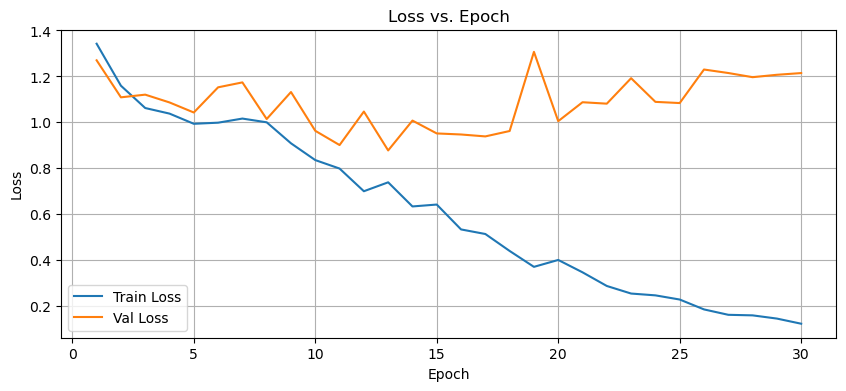

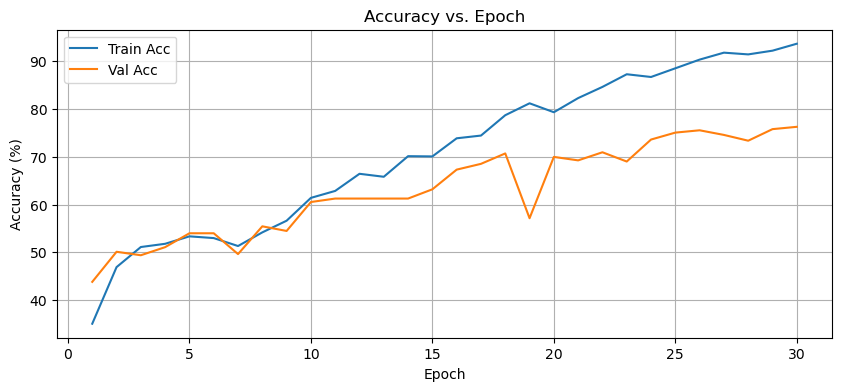

C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Accuracy: 74.58%

                precision    recall  f1-score   support

       Healthy       0.96      0.99      0.98       150
       Mild DR       0.61      0.71      0.66        55
   Moderate DR       0.76      0.67      0.71       135
Proliferate DR       0.45      0.45      0.45        44
     Severe DR       0.32      0.34      0.33        29

      accuracy                           0.75       413
     macro avg       0.62      0.63      0.63       413
  weighted avg       0.75      0.75      0.75       413



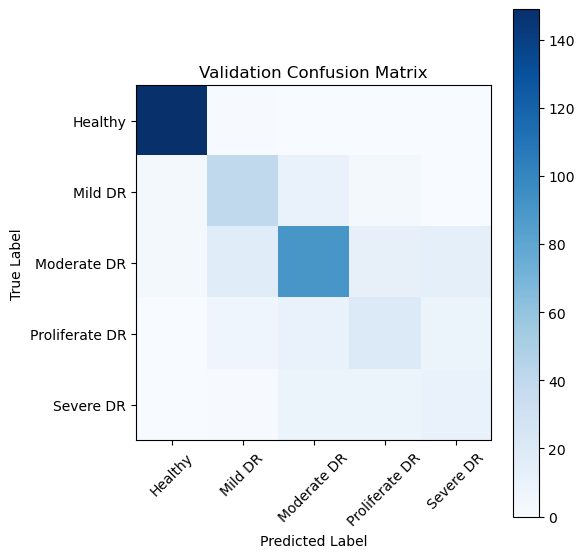

Sample classified as: Severe DR


C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


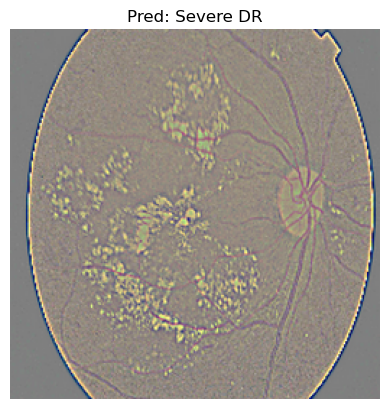

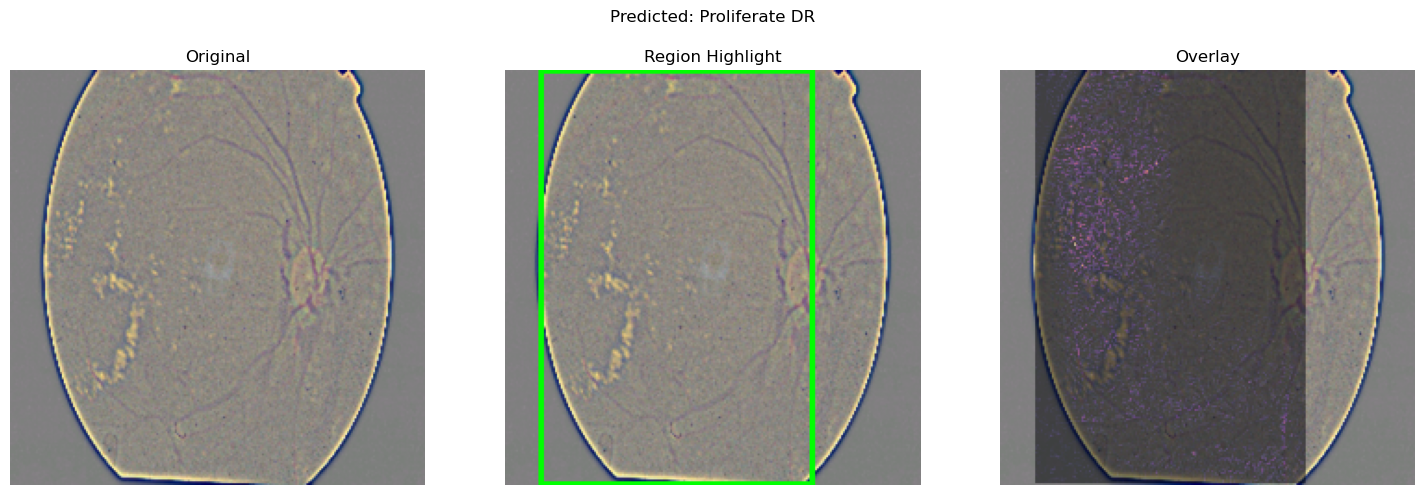

Model weights saved to best_model.pth


In [1]:
#with necessary graphs
# necessary graphs added
# ─── Cell 1: Setup, Data & Two-Phase Fine-Tuning with Metrics and Plots ─────

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# 1) Config
data_dir       = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
batch_size     = 8
phase1_epochs  = 5    # train only head
phase2_epochs  = 25   # fine-tune entire net
max_lr         = 1e-3
momentum       = 0.9
weight_decay   = 1e-4
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Transforms
IMG_SIZE = 224
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 3) Load & stratified split
full_ds = datasets.ImageFolder(data_dir)
indices, labels = list(range(len(full_ds))), full_ds.targets

sss1 = StratifiedShuffleSplit(1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))
temp_labels = [labels[i] for i in temp_idx]
sss2 = StratifiedShuffleSplit(1, test_size=0.50, random_state=42)
val_rel, test_rel = next(sss2.split(temp_idx, temp_labels))
val_idx  = [temp_idx[i] for i in val_rel]
test_idx = [temp_idx[i] for i in test_rel]

# 4) Subsets + balanced sampler
ds_train = datasets.ImageFolder(data_dir, transform=train_tf)
ds_eval  = datasets.ImageFolder(data_dir, transform=eval_tf)
train_ds = Subset(ds_train, train_idx)
val_ds   = Subset(ds_eval,  val_idx)

train_labels = [labels[i] for i in train_idx]
counts       = Counter(train_labels)
class_wts    = [1.0/counts[i] for i in range(len(full_ds.classes))]
sample_wts   = [class_wts[l] for l in train_labels]
sampler      = WeightedRandomSampler(sample_wts, num_samples=len(sample_wts), replacement=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,   num_workers=4)

# 5) Model
model = models.vgg16(pretrained=True)
in_feats = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_feats, len(full_ds.classes))
model.to(device)

# 6) Criterion & writer
class_wts_tensor = torch.tensor(class_wts, device=device)
criterion        = nn.CrossEntropyLoss(weight=class_wts_tensor)
writer           = SummaryWriter(log_dir="runs/dr_two_phase")

# 7) Metrics storage
total_epochs = phase1_epochs + phase2_epochs
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

# ── Phase 1: train only classifier head ──────────────────────────────────────
for p in model.features.parameters():
    p.requires_grad = False

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
sched1    = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
               total_steps=phase1_epochs * len(train_loader),
               pct_start=0.3, div_factor=100, final_div_factor=100)

for epoch in range(phase1_epochs):
    # training
    model.train()
    rl=rc=rt=0
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out   = model(imgs)
        loss  = criterion(out, labs)
        loss.backward(); optimizer.step(); sched1.step()
        rl += loss.item()*imgs.size(0)
        preds = out.argmax(1)
        rc += (preds==labs).sum().item()
        rt += labs.size(0)
    train_loss = rl/rt; train_acc=rc/rt

    # validation
    model.eval()
    vl=vc=vt=0
    with torch.no_grad():
        for imgs, labs in val_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out   = model(imgs)
            loss  = criterion(out, labs)
            vl += loss.item()*imgs.size(0)
            preds= out.argmax(1)
            vc += (preds==labs).sum().item()
            vt += labs.size(0)
    val_loss = vl/vt; val_acc=vc/vt

    # log & store
    writer.add_scalar("Loss/train", train_loss,       epoch)
    writer.add_scalar("Loss/val",   val_loss,         epoch)
    writer.add_scalar("Acc/train",  train_acc*100,    epoch)
    writer.add_scalar("Acc/val",    val_acc*100,      epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Phase1 Ep{epoch+1}/{phase1_epochs}] "
          f"Train L:{train_loss:.4f} A:{train_acc*100:.2f}% | "
          f"Val   L:{val_loss:.4f} A:{val_acc*100:.2f}%")

# ── Phase 2: fine-tune full network ─────────────────────────────────────────
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
sched2    = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
               total_steps=phase2_epochs * len(train_loader),
               pct_start=0.1, div_factor=100, final_div_factor=100)

for epoch in range(phase2_epochs):
    model.train()
    rl=rc=rt=0
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out   = model(imgs)
        loss  = criterion(out, labs)
        loss.backward(); optimizer.step(); sched2.step()
        rl += loss.item()*imgs.size(0)
        preds= out.argmax(1)
        rc += (preds==labs).sum().item()
        rt += labs.size(0)
    train_loss=train_acc= None
    train_loss = rl/rt; train_acc=rc/rt

    model.eval()
    vl=vc=vt=0
    with torch.no_grad():
        for imgs, labs in val_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out  = model(imgs)
            loss = criterion(out, labs)
            vl += loss.item()*imgs.size(0)
            preds= out.argmax(1)
            vc += (preds==labs).sum().item()
            vt += labs.size(0)
    val_loss=vl/vt; val_acc=vc/vt

    global_epoch = phase1_epochs + epoch
    writer.add_scalar("Loss/train", train_loss,    global_epoch)
    writer.add_scalar("Loss/val",   val_loss,      global_epoch)
    writer.add_scalar("Acc/train",  train_acc*100, global_epoch)
    writer.add_scalar("Acc/val",    val_acc*100,   global_epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Phase2 Ep{epoch+1}/{phase2_epochs}] "
          f"Train L:{train_loss:.4f} A:{train_acc*100:.2f}% | "
          f"Val   L:{val_loss:.4f} A:{val_acc*100:.2f}%")

# close writer
writer.close()

# ── Plot Training & Validation Curves ───────────────────────────────────────
epochs = list(range(1, total_epochs+1))

plt.figure(figsize=(10,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss vs. Epoch'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, [a*100 for a in train_accs], label='Train Acc')
plt.plot(epochs, [a*100 for a in val_accs],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch'); plt.legend(); plt.grid(True)
plt.show()

# ─── Cell 3: Evaluate, Plot Confusion Matrix & Sample Inference ────────────

import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from PIL import Image
from torchvision import transforms, models

# 1) Reload model
model = models.vgg16(pretrained=False)
in_feats = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_feats, len(full_ds.classes))
model.load_state_dict(torch.load("dr_vgg16_final_finetuned2.pth", map_location=device))
model.to(device).eval()

# 2) Eval on validation set
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out   = model(imgs)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm  = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc*100:.2f}%\n")
print(classification_report(all_labels, all_preds, target_names=full_ds.classes))

# 3) Plot confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title("Validation Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(full_ds.classes))
plt.xticks(ticks, full_ds.classes, rotation=45)
plt.yticks(ticks, full_ds.classes)
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 4) Sample inference helper
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
def predict_and_show(path):
    img = Image.open(path).convert("RGB")
    x   = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x).argmax(1).item()
    plt.imshow(img); plt.title(f"Pred: {full_ds.classes[pred]}"); plt.axis("off")
    return full_ds.classes[pred]

# Example usage:
sample_path = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_5.png"
print("Sample classified as:", predict_and_show(sample_path))


import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ── CONFIGURATION ───────────────────────────────────────────────────────────────
MODEL_PATH = "vgg16_best_model.pth"  # Your trained model
CLASS_NAMES = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── PREPROCESSOR ─────────────────────────────────────────────────────────────────
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ── MODEL BUILD & LOAD ────────────────────────────────────────────────────────────
model = models.vgg16(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(4096, 1024), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(1024, len(CLASS_NAMES))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# ── HOOKS FOR ACTIVATIONS & GRADIENTS ────────────────────────────────────────────
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

target_layer = model.features[28]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ── GENERATE FOCUSED GRAD-CAM REGION ─────────────────────────────────────────────
def generate_gradcam_region(img_path, percentile=90, pad=15):
    # Validate path
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    # Load and preprocess
    img_pil = Image.open(img_path).convert("RGB")
    inp = preprocess(img_pil).unsqueeze(0).to(DEVICE)
    inp.requires_grad = True

    # Forward + backward for Grad-CAM
    out = model(inp)
    cls_idx = int(out.argmax(dim=1).item())
    score = out[0, cls_idx]
    model.zero_grad()
    score.backward(retain_graph=True)

    # Compute CAM
    weights = gradients.mean(dim=(2,3), keepdim=True)
    cam = (weights * activations).sum(dim=1).squeeze().cpu().numpy()
    cam = np.clip(cam, 0, None)
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

    # Guided Backprop for sharpened gradient
    model.zero_grad()
    score.backward()
    grad_input = inp.grad.cpu().squeeze().numpy()
    guided = np.clip(np.max(grad_input, axis=0), 0, None)
    guided = (guided - guided.min())/(guided.max()-guided.min()+1e-8)

    # Fuse CAM + guided backprop
    fused = cam * guided
    fused = (fused - fused.min())/(fused.max()-fused.min()+1e-8)

    # Smooth + threshold
    blurred = cv2.GaussianBlur((fused*255).astype(np.uint8), (9,9), 0)/255.0
    mask = blurred >= np.percentile(blurred, percentile)

    # Bounding box of salient region
    coords = np.column_stack(np.where(mask))
    if coords.size:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        x0, y0 = max(x0-pad, 0), max(y0-pad, 0)
        x1, y1 = min(x1+pad, IMG_SIZE-1), min(y1+pad, IMG_SIZE-1)
    else:
        x0, y0, x1, y1 = 0,0,IMG_SIZE-1,IMG_SIZE-1

    # Prepare visuals
    orig = np.array(img_pil.resize((IMG_SIZE, IMG_SIZE)))
    heat = (fused*255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heat, cv2.COLORMAP_MAGMA)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Masked overlay only in region
    overlay = orig.copy()
    sub_orig = orig[y0:y1, x0:x1]
    sub_heat = heatmap[y0:y1, x0:x1]
    sub_blend = cv2.addWeighted(sub_orig, 0.5, sub_heat, 0.5, 0)
    overlay[y0:y1, x0:x1] = sub_blend

    # Highlight box on a copy
    boxed = orig.copy()
    cv2.rectangle(boxed, (x0,y0), (x1,y1), (0,255,0), 2)

    return orig, boxed, overlay, cls_idx

# ── SHOW RESULTS ─────────────────────────────────────────────────────────────────
def show_gradcam(img_path, percentile=90, pad=15):
    orig, boxed, overlay, idx = generate_gradcam_region(img_path, percentile, pad)
    plt.figure(figsize=(15,5))
    titles = ["Original", "Region Highlight", "Overlay"]
    for i,img in enumerate([orig, boxed, overlay],1):
        ax = plt.subplot(1,3,i)
        ax.imshow(img)
        ax.set_title(titles[i-1])
        ax.axis('off')
    plt.suptitle(f"Predicted: {CLASS_NAMES[idx]}")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# ── EXAMPLE USAGE ─────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Replace with your actual image path on your system:
    sample_path = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Proliferate DR\Proliferate DR_8.png"
    show_gradcam(sample_path, percentile=95, pad=10)
# ─── Cell 2: Save the Fine-Tuned Model ───────────────────────────────────────

import torch
torch.save(model.state_dict(), "best_model.pth")
print("Model weights saved to best_model.pth")
